**GW19_PFC_CP**

# Libraries

In [62]:
import numpy as np
import pandas as pd
import scanpy as sc
import triku as tk

In [63]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.9.2 umap==0.5.3 numpy==1.21.1 scipy==1.8.0 pandas==1.2.4 scikit-learn==1.1.1 statsmodels==0.13.2 igraph==0.9.10 pynndescent==0.5.7


In [64]:
results_file = '/group/testa/Project/CBOProgPools/h5ad/GW19_03_20240209_v1.h5ad'  # the file that will store the analysis results

In [65]:
geschwind_ext = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}

In [66]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations
# of the data. It also comes with its own HDF5-based file format: .h5ad.
adata = sc.read_10x_mtx(
    '/group/testa/Project/CBOProgPools/data/GW19_PFC_CP/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/group-testa-Project-CBOProgPools-data-GW19_PFC_CP-matrix.h5ad


In [67]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [68]:
adata

AnnData object with n_obs × n_vars = 4426 × 33694
    var: 'gene_ids'

# Data Preparation

normalizing counts per cell
    finished (0:00:00)


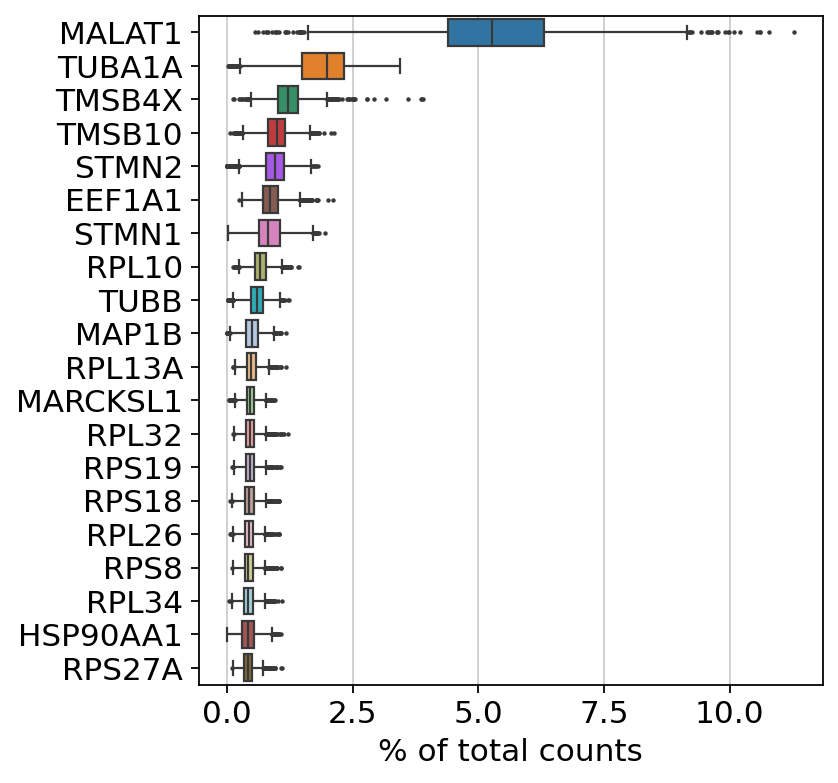

In [69]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )


In [70]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)

filtered out 22072 genes that are detected in less than 50 cells


In [71]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var['ribo'] = adata.var_names.str.startswith('RPL')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

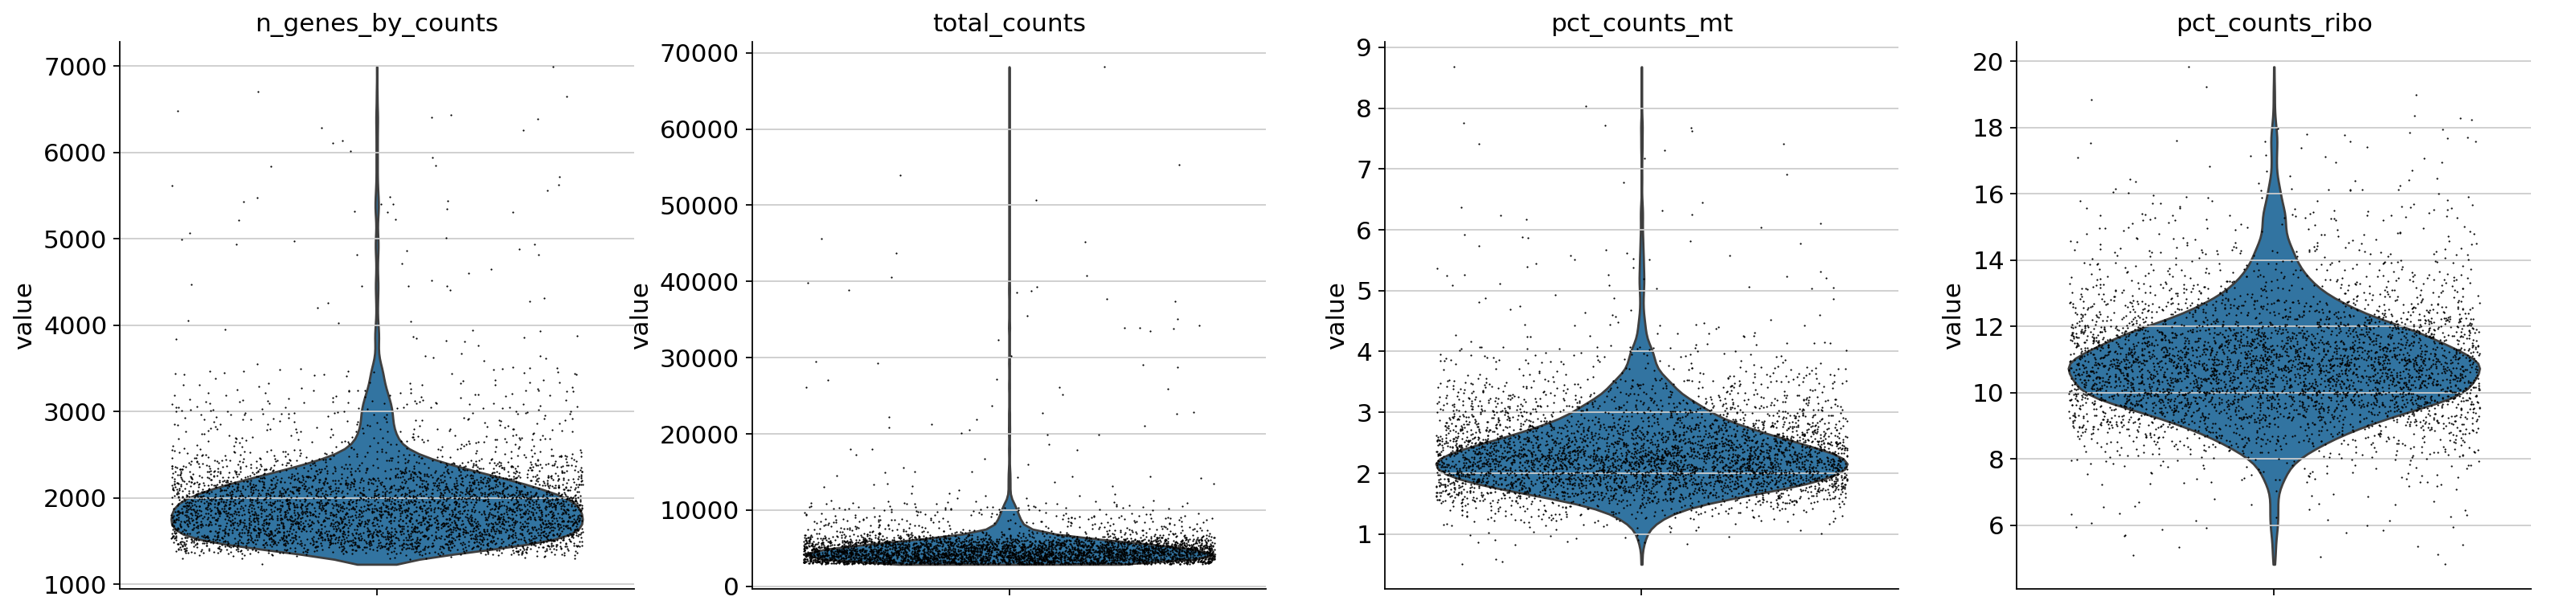

In [72]:
# A violin plot of some of the computed quality measures:
   # the number of genes expressed in the count matrix
   # the total counts per cell
   # the percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

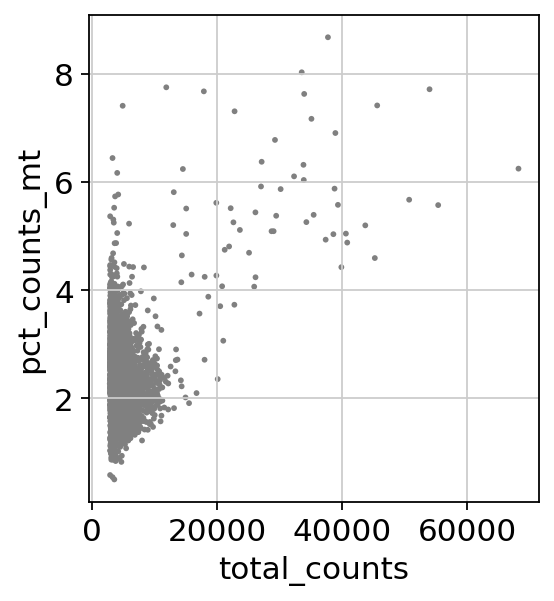

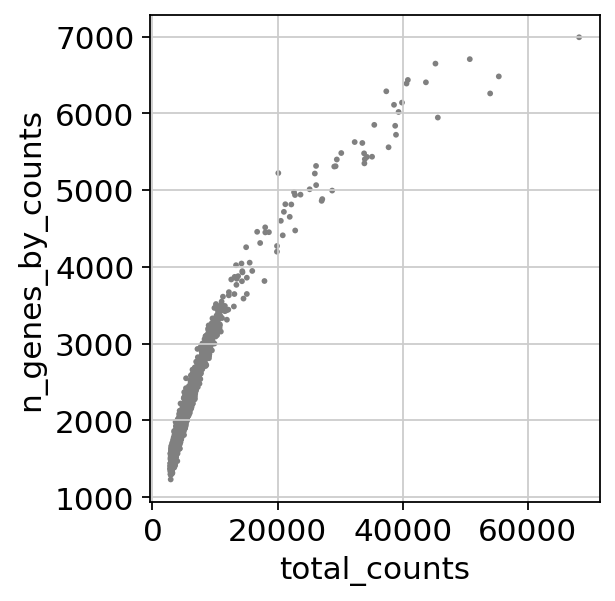

In [73]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [74]:
adata = adata[adata.obs.total_counts <= 15000]

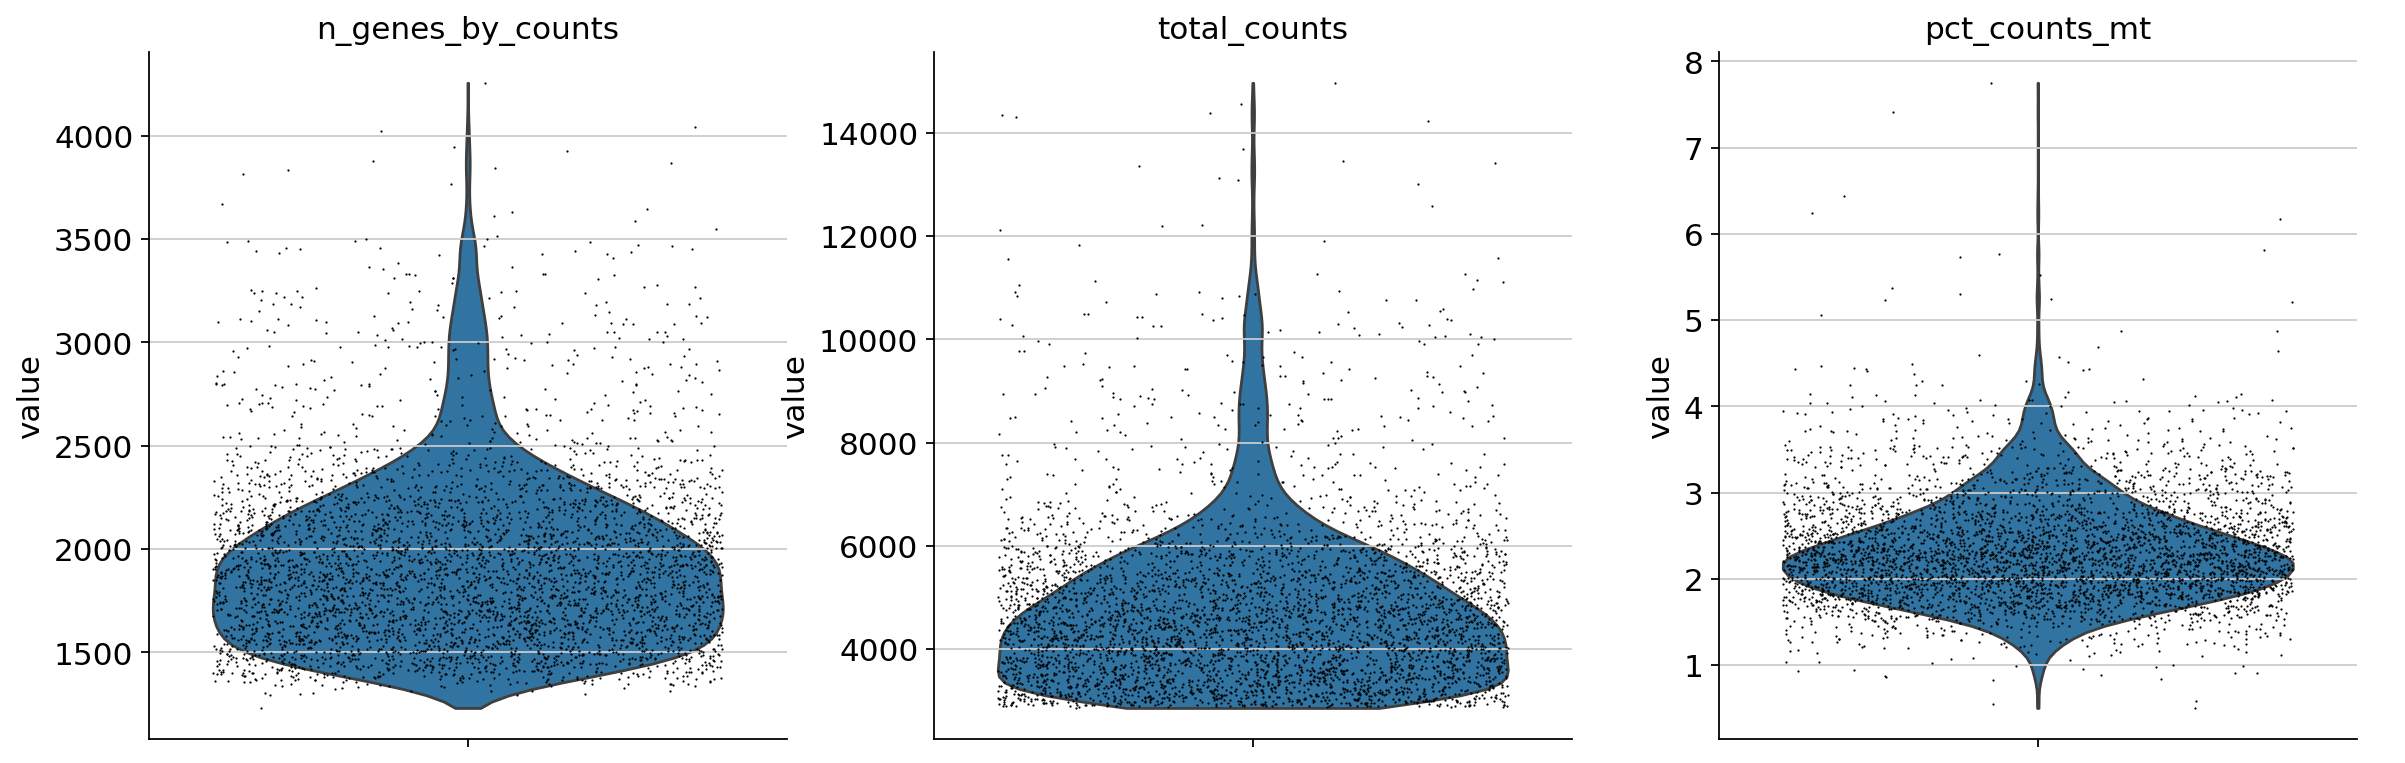

In [75]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [76]:
s_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/S_genes",index_col=0,header=None)
g2m_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/G2M_genes",index_col=0,header=None)
sc.tl.score_genes_cell_cycle(adata,s_genes.index,g2m_genes.index)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    771 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    643 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [77]:
adata.obs.keys()

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score',
       'G2M_score', 'phase'],
      dtype='object')

In [78]:
adata.obs.phase.value_counts()

G2M    2181
G1     1172
S      1015
Name: phase, dtype: int64

In [79]:
sc.external.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 4.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.3%
    Scrublet finished (0:00:02)


In [80]:
adata.obs.predicted_doublet.value_counts()

False    4361
True        7
Name: predicted_doublet, dtype: int64

In [81]:
adata.raw = adata.copy()
adata.layers['Raw'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=15000) # highest meaningful coverage (see tot_counts)
adata.layers['normalized'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['logNorm'] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [82]:
adata

AnnData object with n_obs × n_vars = 4368 × 11622
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'scrublet', 'log1p'
    layers: 'Raw', 'normalized', 'logNorm'

In [83]:
sc.pp.pca(adata, use_highly_variable=False)

sc.pp.neighbors(adata, metric='cosine', n_neighbors=int(0.5 * len(adata) ** 0.5)) #25 , 50. 75, 100
 
## Triku

tk.tl.triku(adata, use_raw=False)

Top20Triku = adata.var.sort_values(by=['triku_distance'], ascending=False).head(20).index
Top20Triku

computing PCA
    with n_comps=50
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


Index(['ZFP36L1', 'CD9', 'ATP1A2', 'RGCC', 'FAT1', 'PON2', 'ZEB1', 'ST18',
       'ANXA5', 'GABRA5', 'MT2A', 'CD99', 'S100A16', 'IFITM3', 'RAB31', 'HES1',
       'SEMA5A', 'RGMA', 'SYNPR', 'MFGE8'],
      dtype='object')

In [84]:
adata.var_names[adata.var['highly_variable'] == True]

Index(['AJAP1', 'CLSTN1', 'KAZN', 'IGSF21', 'PTPRU', 'FABP3', 'HPCA', 'CSMD2',
       'CLSPN', 'GRIK3',
       ...
       'PEG3', 'PCDH11Y', 'ADRBK2', 'SEZ6L', 'SYN3', 'LGALS1', 'KIAA1644',
       'NCAM2', 'ETS2', 'PCP4'],
      dtype='object', length=619)

# Principle Component Analysis

In [85]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main 
# axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


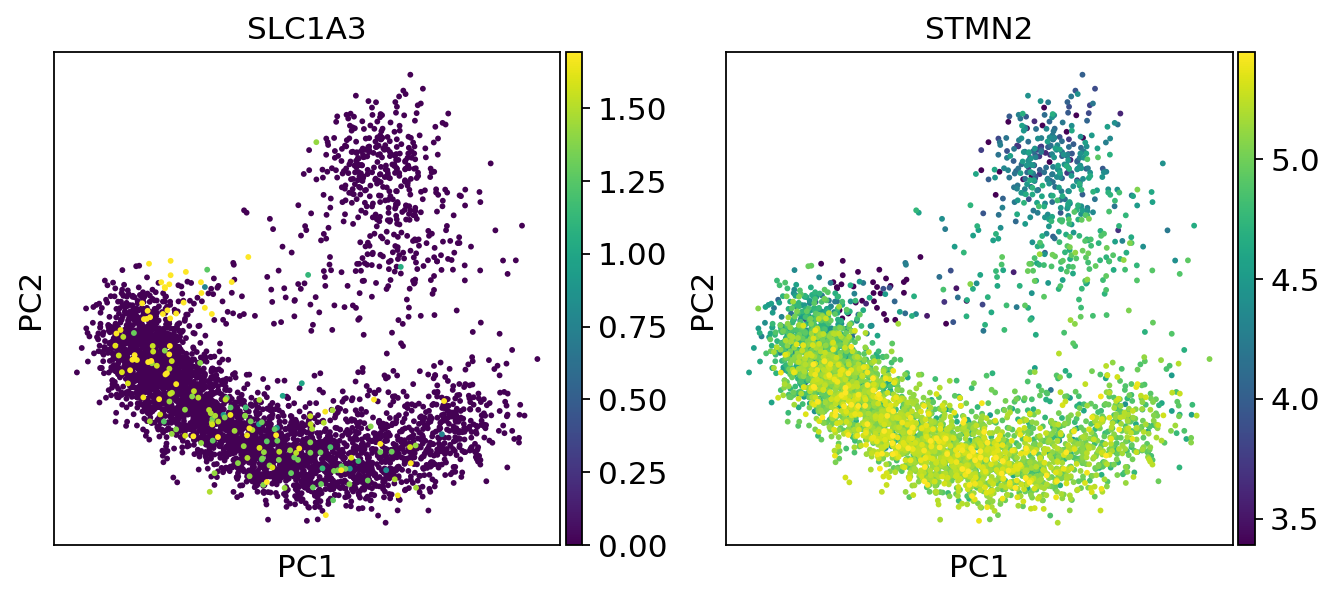

In [86]:

# MKI67 = cycling cell (usually progenitors, aRG / bRG / IP)
# EOMES = IP specific
# SLC1A3 = Radial Glia in general, including glia
# HOPX = bRG specific
# DCX = immature neurons
# STMN2 neurons in general

sc.pl.pca(adata, color=['SLC1A3','STMN2'],use_raw=False,vmin="p1",vmax="p99") 

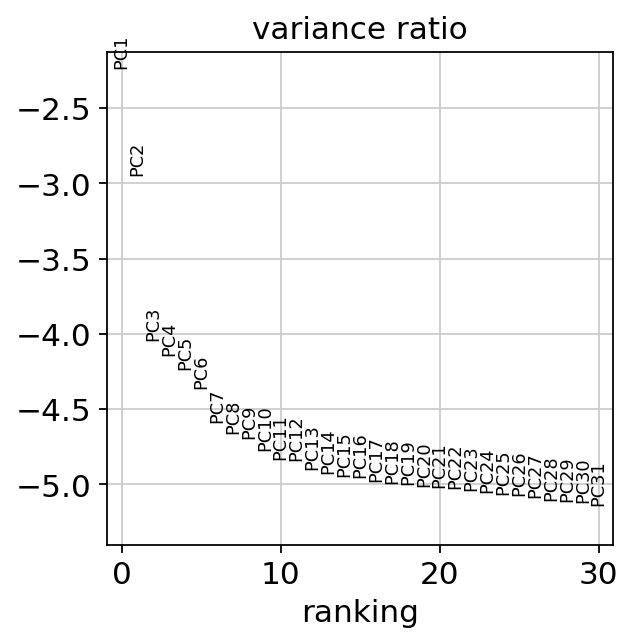

In [87]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
# saving the result
adata.write(results_file)

In [89]:
adata

AnnData object with n_obs × n_vars = 4368 × 11622
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'scrublet', 'log1p', 'pca', 'neighbors', 'triku_params'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Raw', 'normalized', 'logNorm'
    obsp: 'distances', 'connectivities'

# Computing Neighborhood Graph 

In [90]:
int(0.5 * len(adata) ** 0.5)

33

In [91]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. 
# You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=7)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


# Embedding Neighborhood Graph

In [92]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")
# small resolution ==> less clusters 
# 0.4 - 1.5

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [93]:
adata.obs.leiden.value_counts()

0    1267
1    1028
2     725
3     450
4     372
5     258
6     165
7     103
Name: leiden, dtype: int64

In [94]:
# We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 
# It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it 
# better preserves trajectories. In some ocassions, you might still observe disconnected clusters and
# similar connectivity violations. They can usually be remedied by running:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [95]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


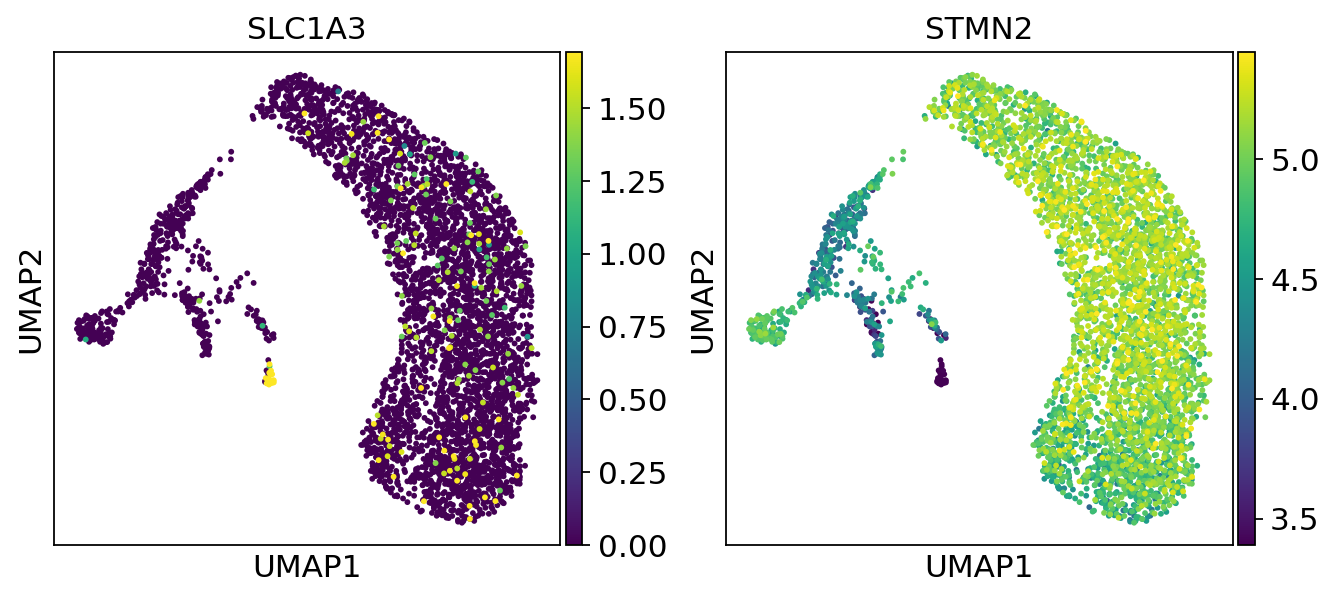

In [96]:
# As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) 
# gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to 
# use .raw.
sc.pl.umap(adata, color=['SLC1A3','STMN2'], use_raw=False,vmin="p1",vmax="p99")

# Clustering Neighborhood Graph

In [97]:
# saving results
#adata.write(results_file)

# Finding Gene Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


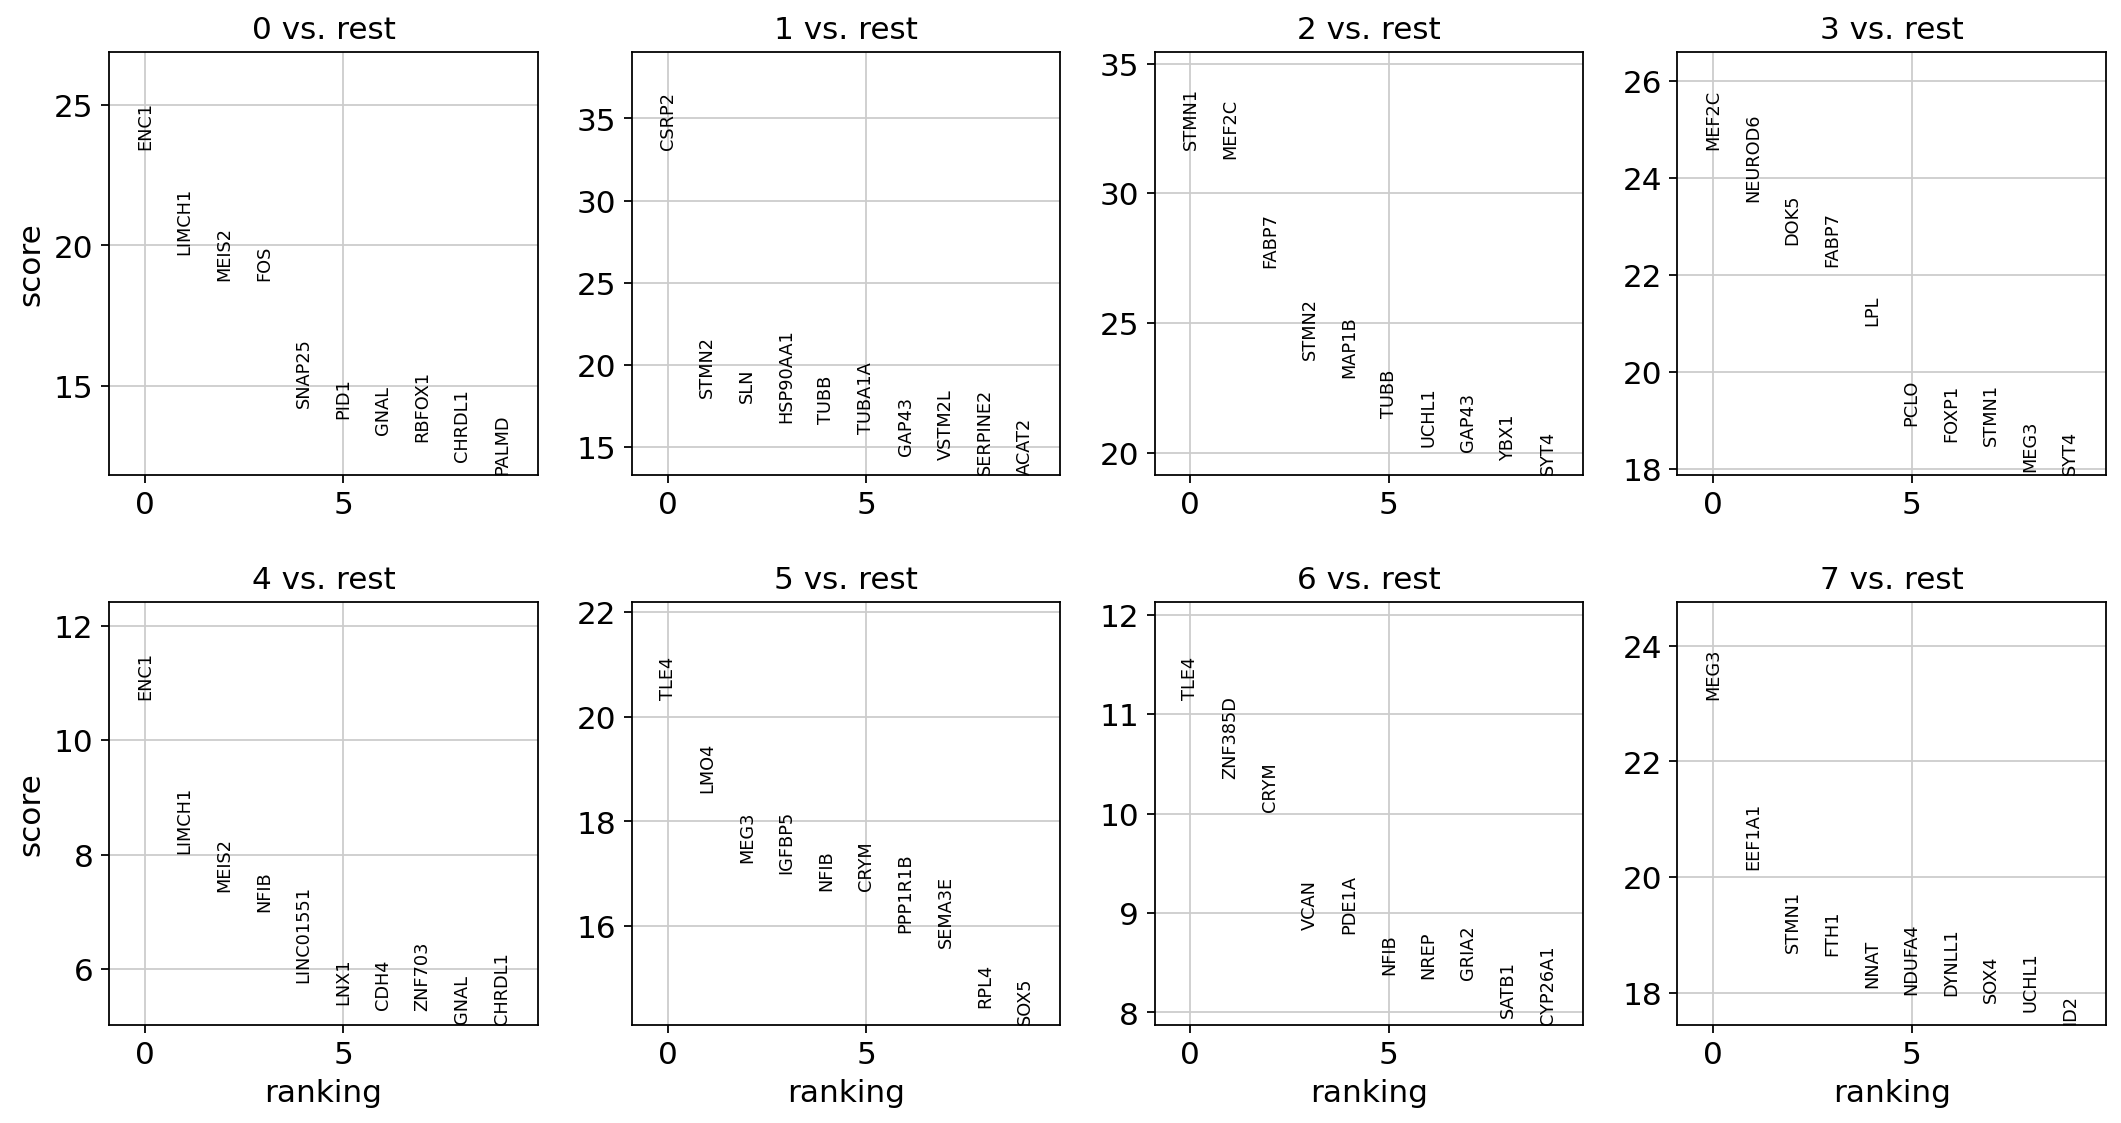

In [98]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [99]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p       1_n            1_p    2_n            2_p  \
0    ENC1  7.089376e-109     CSRP2  2.763341e-188  STMN1  2.743389e-158   
1  LIMCH1   3.473452e-79     STMN2   1.381363e-67  MEF2C  9.770282e-154   
2   MEIS2   2.151564e-72       SLN   2.894571e-63  FABP7  9.115703e-125   
3     FOS   1.141872e-73  HSP90AA1   5.480889e-57  STMN2  1.309634e-100   
4  SNAP25   3.509697e-44      TUBB   2.661724e-57  MAP1B   2.088128e-95   

       3_n           3_p        4_n           4_p     5_n           5_p  \
0    MEF2C  9.811378e-91       ENC1  3.904264e-24    TLE4  8.506449e-56   
1  NEUROD6  2.876518e-82     LIMCH1  9.913918e-15    LMO4  1.888608e-50   
2     DOK5  8.066806e-79      MEIS2  9.082525e-13    MEG3  2.098002e-46   
3    FABP7  2.469319e-78       NFIB  8.715382e-12  IGFBP5  4.841564e-44   
4      LPL  5.647150e-69  LINC01551  1.610408e-08    NFIB  8.408251e-44   

       6_n           6_p     7_n           7_p  
0     TLE4  6.871275e-22    MEG3  1.320706e-42  
1  ZNF385D  1.128281e-19  EEF1A1  1.409159e-37  
2     CRYM  8.747207e-19   STMN1  2.153063e-35  
3     VCAN  1.404751e-15    FTH1  5.842231e-35  
4    PDE1A  1.752179e-15    NNAT  6.183983e-34

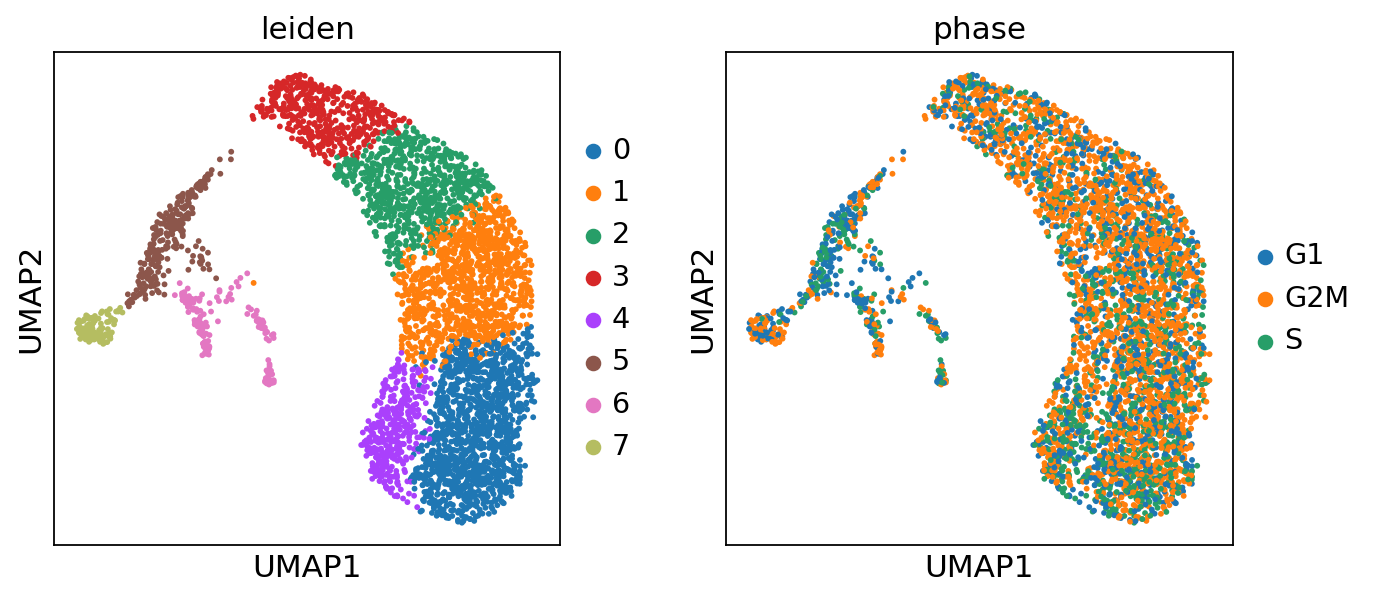

In [101]:
sc.pl.umap(adata,color=["leiden","phase"])

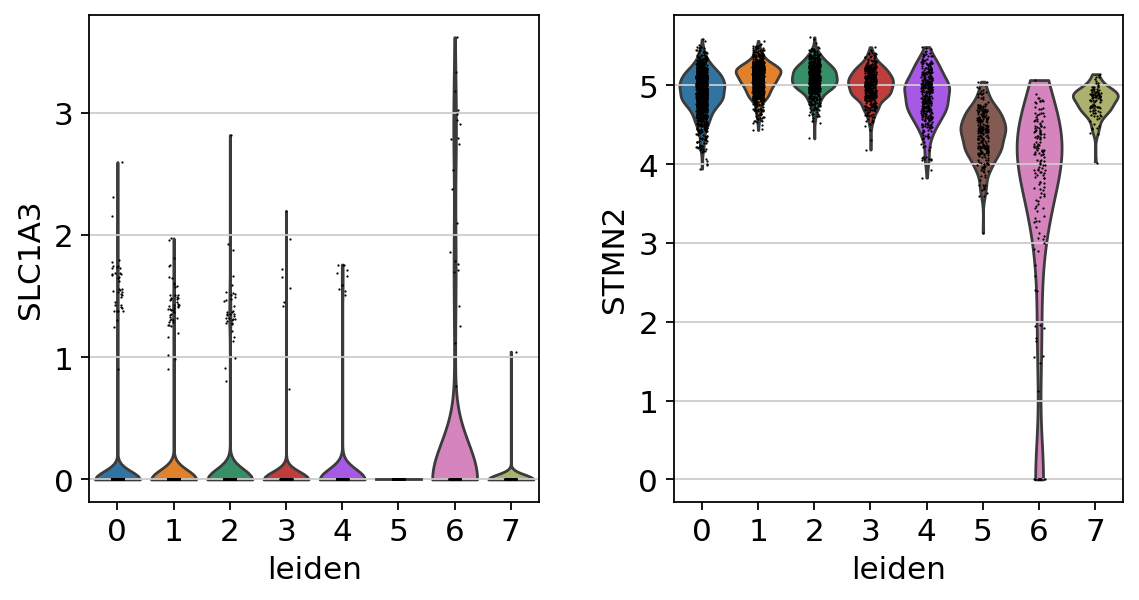

In [102]:
sc.pl.violin(adata, [ 'SLC1A3','STMN2'], groupby='leiden',use_raw=False)

In [103]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0         1      2        3          4        5        6       7
0    ENC1     CSRP2  STMN1    MEF2C       ENC1     TLE4     TLE4    MEG3
1  LIMCH1     STMN2  MEF2C  NEUROD6     LIMCH1     LMO4  ZNF385D  EEF1A1
2   MEIS2       SLN  FABP7     DOK5      MEIS2     MEG3     CRYM   STMN1
3     FOS  HSP90AA1  STMN2    FABP7       NFIB   IGFBP5     VCAN    FTH1
4  SNAP25      TUBB  MAP1B      LPL  LINC01551     NFIB    PDE1A    NNAT
5    PID1    TUBA1A   TUBB     PCLO       LNX1     CRYM     NFIB  NDUFA4
6    GNAL     GAP43  UCHL1    FOXP1       CDH4  PPP1R1B     NREP  DYNLL1
7  RBFOX1    VSTM2L  GAP43    STMN1     ZNF703   SEMA3E    GRIA2    SOX4
8  CHRDL1  SERPINE2   YBX1     MEG3       GNAL     RPL4    SATB1   UCHL1
9   PALMD     ACAT2   SYT4     SYT4     CHRDL1     SOX5  CYP26A1     ID2

In [104]:
marker_genes = ['leiden','ENC1', 'LIMCH1','CSRP2','STMN2','MEF2C','STMN1','TLE4','CRYM','MEG3','EEF1A1','SOX2','PTN']

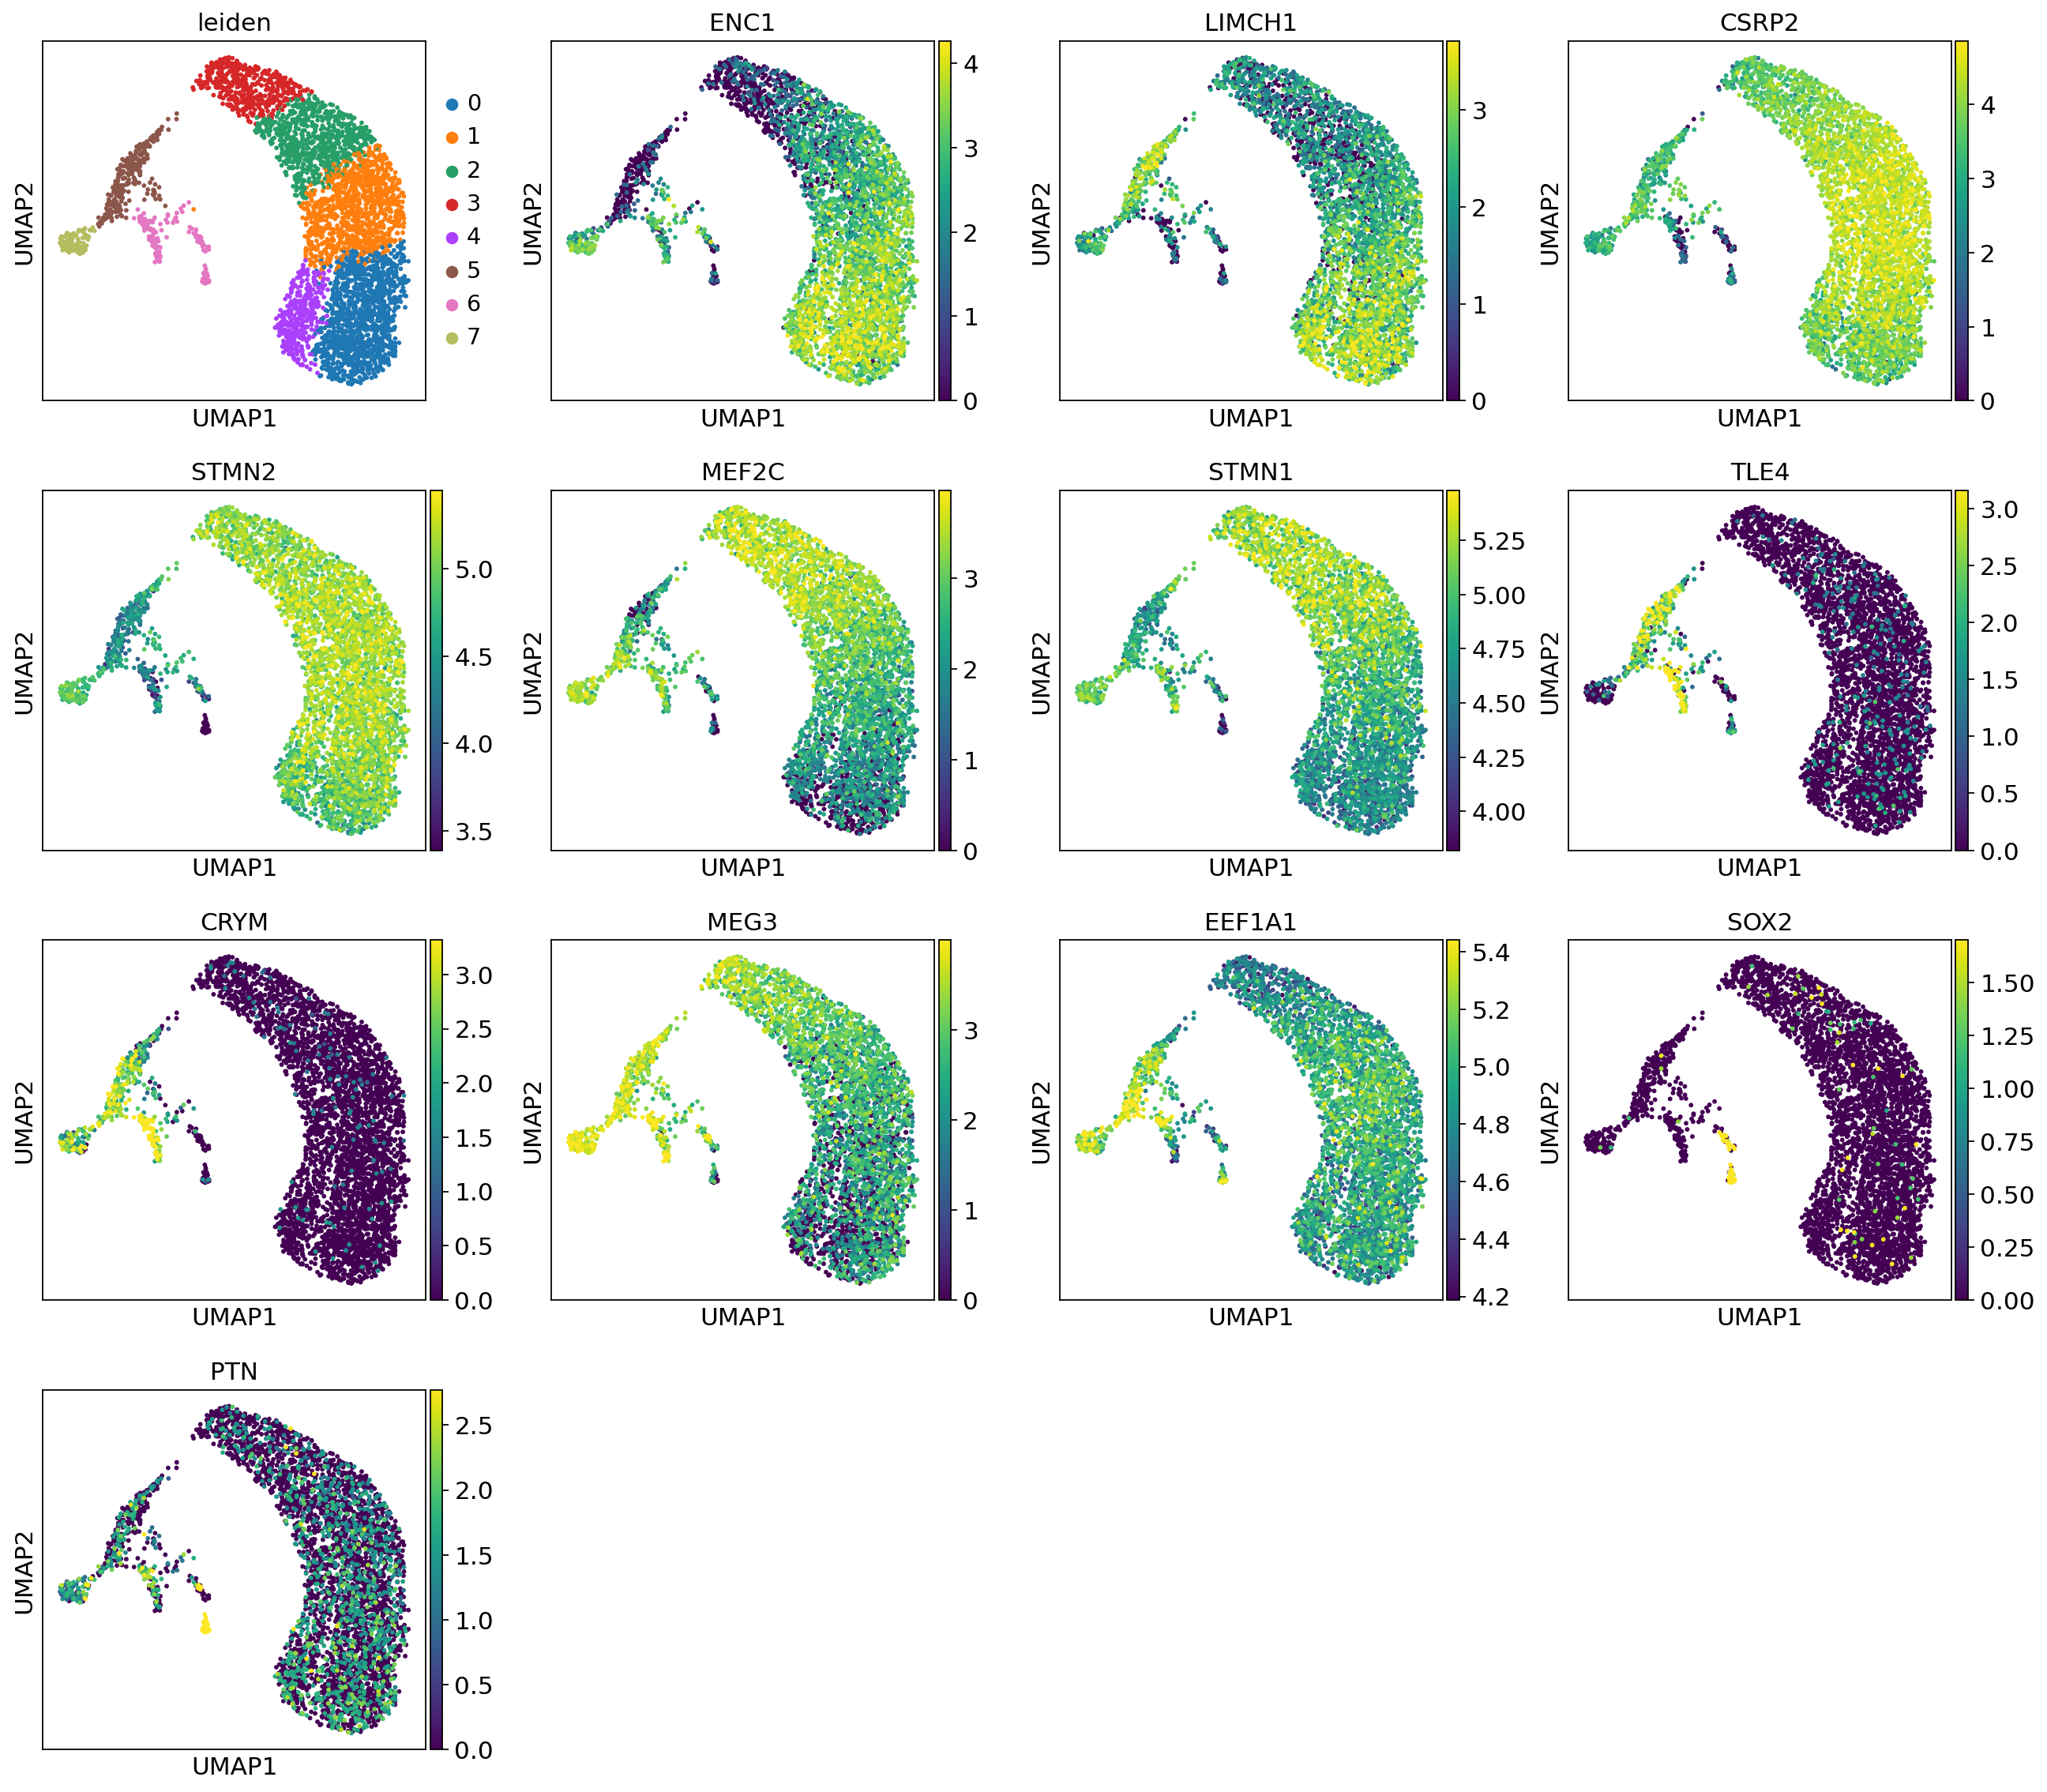

In [105]:
sc.pl.umap(adata,color=marker_genes,vmin="p1",vmax="p99",use_raw=False)

In [106]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9958611  0.9912498  0.98693997 0.984772   0.9788402
     0.9761173  0.94899833 0.9406554  0.92306364 0.92025036 0.91891414
     0.9003073  0.8973235  0.8890641 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


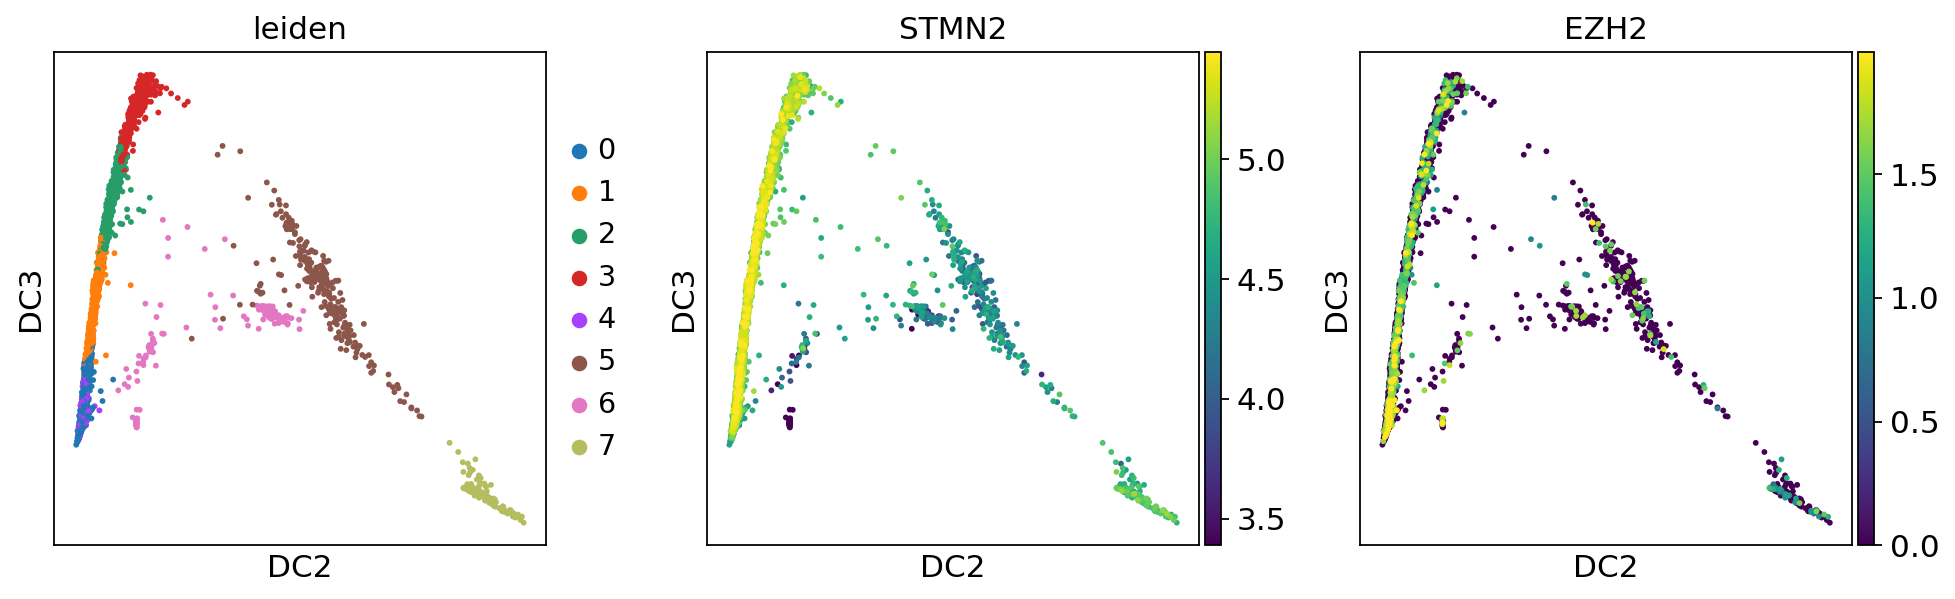

In [107]:
sc.pl.diffmap(adata,color=["leiden", 'STMN2','EZH2'],dimensions=(1,2),vmin='p1',vmax='p99',use_raw=False)

In [108]:
#sc.tl.leiden(adata,resolution=0.5,key_added="leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: endothelial, ExcDeepLayer, Interneurons, etc.


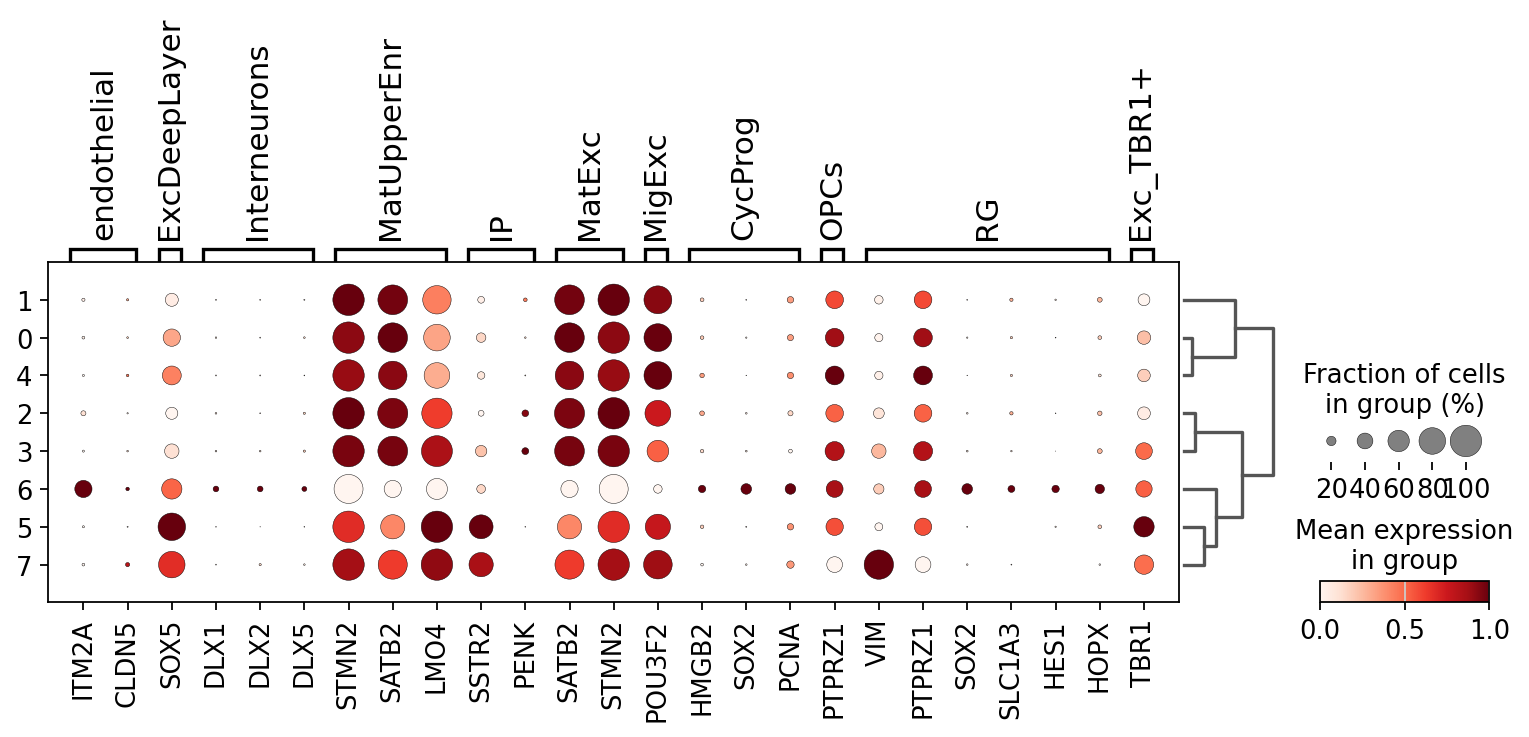

In [109]:
geschwind_ext = {
  'endothelial' : ['ITM2A','CLDN5'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['SSTR2','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','PCNA'],
  'OPCs' : ['PTPRZ1'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_TBR1+' : ['TBR1']
}

sc.pl.dotplot(adata,geschwind_ext , 'leiden', dendrogram=True,save="combo_markersDotplot",use_raw=False,log=True,standard_scale='var')

In [110]:
cluster2annotation = {
     "0": "Neu", "1": "Neu","2":"Neu", "3": "Neu",
    "4": "Neu", "5": "Neu", "6": "RG", "7": "RG"
}
 
adata.obs['celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [111]:

cluster2annotation = {
     "0": "Mig/Mat", "1": "ExcMat/Upp","2":"MatUpp", "3": "MatUpp",
    "4": "Mig/Mat", "5": "DeepLayer/IP", "6": "oRG", "7": "vRG",
}
 
adata.obs['celltype2'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [112]:
new_cluster_names = [
    '0/Mig/Mat', '1/ExcMat/Upp',
    '2/MatUpp', '3/MatUpp',
    '4/Mig/Mat','5/DeepLayer/IP','6/oRG','7/vRG',
    ]
adata.rename_categories('leiden', new_cluster_names)

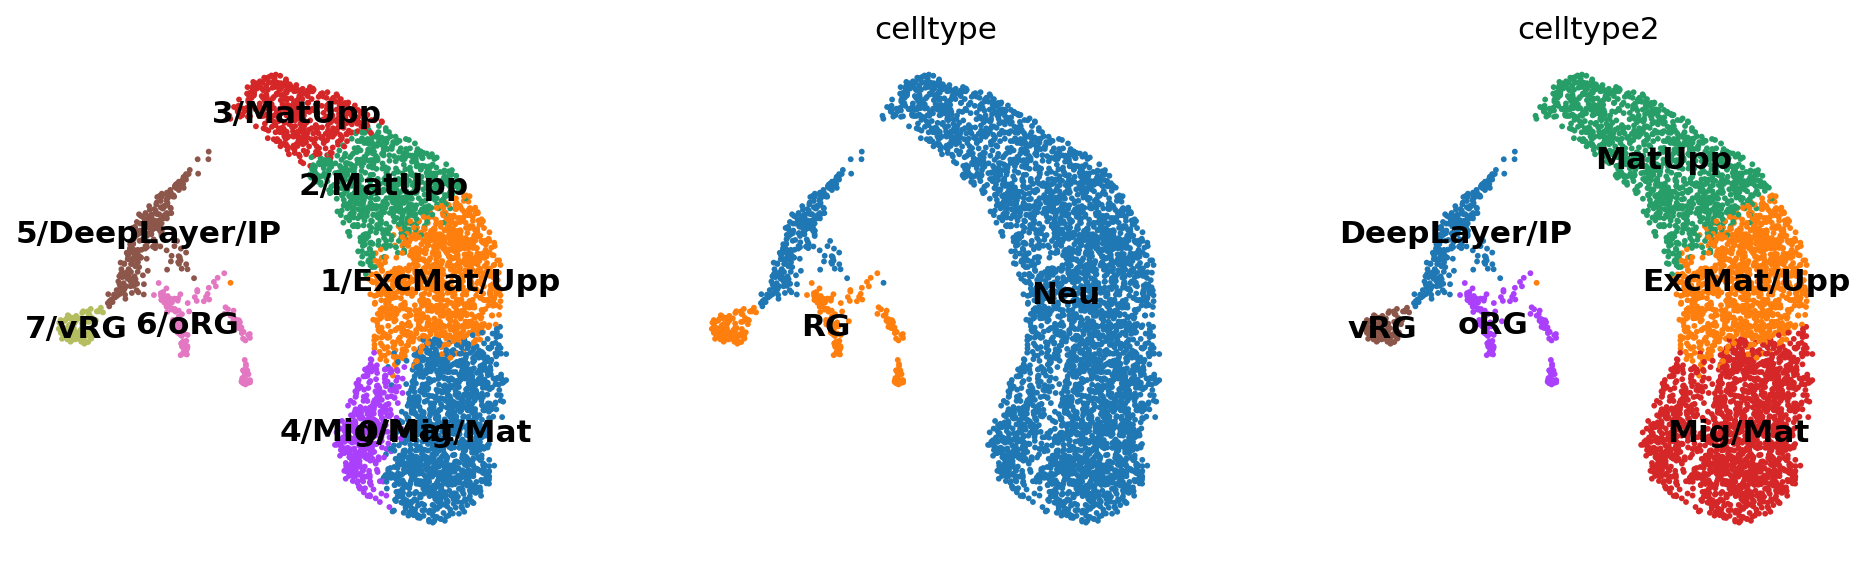

In [113]:
sc.pl.umap(adata, color=['leiden','celltype','celltype2'], legend_loc='on data', title='', frameon=False, save='.pdf')

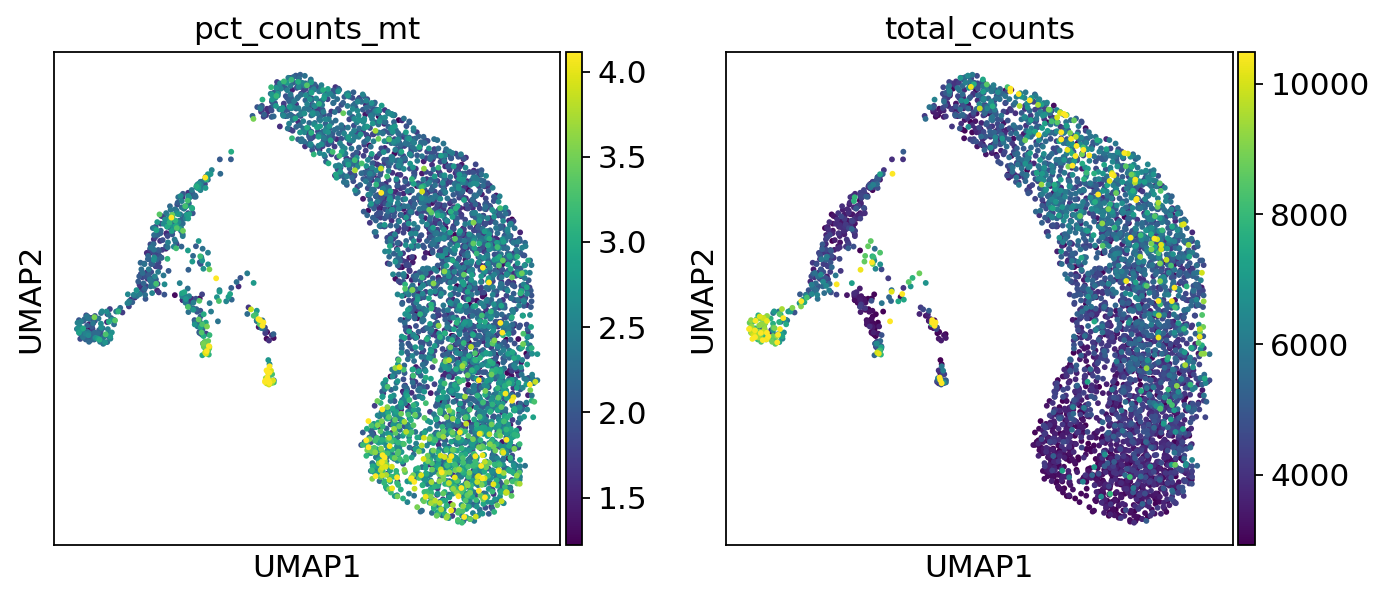

In [114]:
sc.pl.umap(adata,color=['pct_counts_mt','total_counts'],vmin='p1',vmax='p99')

In [115]:
sc.tl.dendrogram(adata,"leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [116]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9958611  0.9912498  0.98693997 0.984772   0.9788402
     0.9761173  0.94899833 0.9406554  0.92306364 0.92025036 0.91891414
     0.9003073  0.8973235  0.8890641 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [117]:
adata.obs.leiden.value_counts()

0/Mig/Mat         1267
1/ExcMat/Upp      1028
2/MatUpp           725
3/MatUpp           450
4/Mig/Mat          372
5/DeepLayer/IP     258
6/oRG              165
7/vRG              103
Name: leiden, dtype: int64

In [119]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9958611  0.9912498  0.98693997 0.984772   0.9788402
     0.9761173  0.94899833 0.9406554  0.92306364 0.92025036 0.91891414
     0.9003073  0.8973235  0.8890641 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


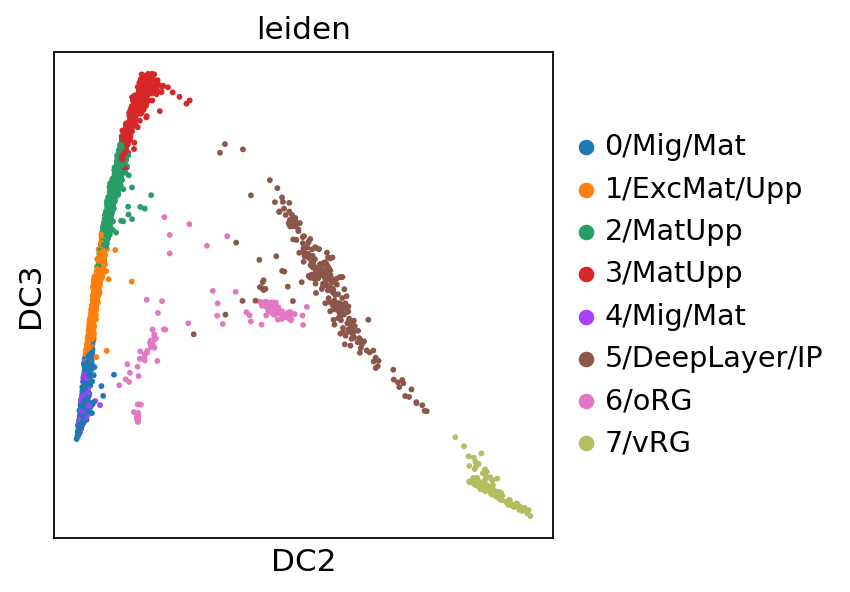

In [120]:
sc.pl.diffmap(adata,color="leiden",dimensions=(1,2))

In [121]:
adata.obs.leiden

AAACCTGAGGCAGGTT-1        2/MatUpp
AAACCTGAGTGGAGTC-1           7/vRG
AAACCTGCAATAACGA-1       4/Mig/Mat
AAACCTGGTAACGTTC-1        2/MatUpp
AAACCTGTCCTTGCCA-1       0/Mig/Mat
                          ...     
TTTGGTTTCTGACCTC-1       0/Mig/Mat
TTTGTCAAGAGACGAA-1       0/Mig/Mat
TTTGTCACACACGCTG-1    1/ExcMat/Upp
TTTGTCACATCTCGCT-1    1/ExcMat/Upp
TTTGTCATCCGAATGT-1       0/Mig/Mat
Name: leiden, Length: 4368, dtype: category
Categories (8, object): ['0/Mig/Mat', '1/ExcMat/Upp', '2/MatUpp', '3/MatUpp', '4/Mig/Mat', '5/DeepLayer/IP', '6/oRG', '7/vRG']

In [127]:
adata=sc.read_h5ad("/group/testa/Project/CBOProgPools/h5ad/GW19_03_20240209_v1.h5ad")

In [128]:
adata.obs['stage'] = 'GW19'

In [129]:
adata.write_h5ad('/group/testa/Project/CBOProgPools/h5ad/GW19_03_20240209_v1.h5ad')